# Figures for SWAPnet experiment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# data structures
DATESTR = "20210818"
TIMESTAMP = "1629190714052"
N_EXPERIMENTS = 250

# These arrays are shape `(N_EXPERIMENTS, 4)
# First axis corresponds to which path on hardware
# second axis has four entries:
#   0: F_LE
#   1: E[F]
#   2: F0 [either with or without readout error depending on the raw vs corr]
# Third axis corresponds to which computational basis state |j> was used
results_corr = np.load(f"./results/v1_hw_{DATESTR}_swapnet_line_results_corr.npy")
results_raw = np.load(f"./results/v1_hw_{DATESTR}_swapnet_line_results_raw.npy")

assert results_corr.shape == (N_EXPERIMENTS, 3)

# This array is shaped `(N_EXPERIMENTS, 3)`
# The second axis is three pairs of (row, col) coordinates describing path placement
used_paths = np.load(f"./results/v1_hw_{DATESTR}_swapnet_line_vs_random_paths.npy")


N_TRIALS = 5

# These arrays are shape `(N_EXPERIMENTS, N_TRIALS)`
random_results_raw = np.load(f"./results/v1_hw_{DATESTR}_random_line_results_raw.npy")
random_results_corr = np.load(f"./results/v1_hw_{DATESTR}_random_line_results_corr.npy")

assert random_results_corr.shape == (N_EXPERIMENTS, N_TRIALS)


In [5]:
from qbitmap import postprocess
import os

# Load in a `(n_experiments, 2, n_qubits)` array of single qubit bitpflips.
readout_path = os.path.join(os.getcwd(), "readout_ec")
qvals_arr = postprocess.load_qvals_arr(timestamp=TIMESTAMP, n_experiments=N_EXPERIMENTS, path=readout_path)


In [6]:
# v4 data: full sweep, but no random
BF_REJECTION = 0.15
idx = postprocess.accept_by_bitflip(BF_REJECTION, qvals_arr)

x = np.arange(len(idx))
F0_corr = results_corr[idx,2]

# In original experiment we messed up the math for the fidelity
# computation. Here I'm fixing that slip up.
F_corr = results_corr[idx,1] * 2 - 1
F_LE_corr = results_corr[idx,0]
F_LE_RAND_corr = random_results_corr[idx,:]

rejected 22 events for qmax>0.15


# Make swapnet figures

In [8]:
from qbitmap import postprocess

parr = np.linspace(75, 95, 21)

x1 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(FLE_rand_corr_mean, F_corr, percentile) for percentile in parr])
x1_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, FLE_rand_corr_mean, F_corr, percentile, ntrials=1000))
        for percentile in parr
])


x2 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(F_LE_corr, F_corr, percentile) for percentile in parr])
x2_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, F_LE_corr, F_corr, percentile, ntrials=1000))
        for percentile in parr
])

x3 = np.asarray([postprocess.Y_gt_y_X_gt_X_conditional(F0_corr, F_corr, percentile) for percentile in parr])
x3_err = np.asarray([
    np.std(bootstrap_metric(postprocess.Y_gt_y_X_gt_X_conditional, F0_corr, F_corr, percentile, ntrials=1000))
        for percentile in parr
])

x4 = 1 - parr/100



/home/ares/projects/qbitmap/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


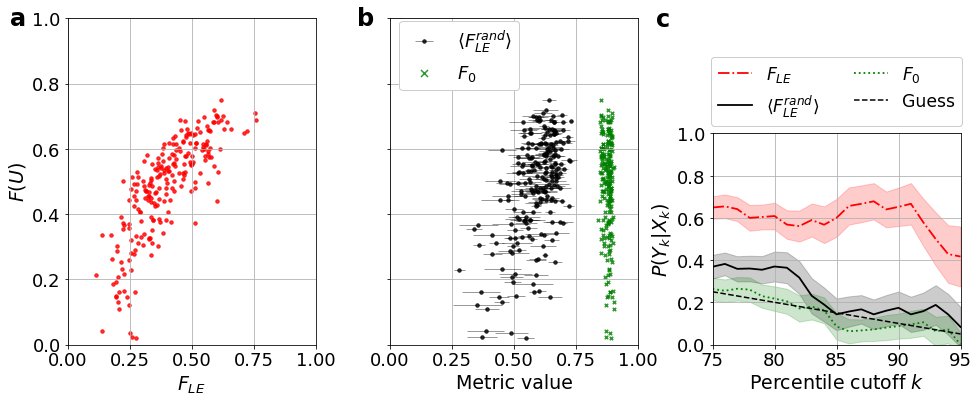

In [9]:
plt.style.use('../../style.mplstyle')
from scipy.stats import kendalltau


fig = plt.figure(figsize=(16, 6))

gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.3)
ax0 = fig.add_subplot(gs[0:3,0])
ax1 = fig.add_subplot(gs[0:3,1], sharey=ax0)
ax2 = fig.add_subplot(gs[1:3,2])
ax3 = fig.add_subplot(gs[1, 1])



plt.style.use('../../style.mplstyle')
s = 12 # dotsize
alpha = 0.8


# Random performance
FLE_rand_corr_err = F_LE_RAND_corr.std(axis=1) 
FLE_rand_corr_mean = F_LE_RAND_corr.mean(axis=1)

# Compute correlation coefficients
r_FLE_F = kendalltau(F_LE_corr, F_corr)[0]
r_FLE_rand_F = kendalltau(FLE_rand_corr_mean, F_corr)[0] 
r_F0_F = kendalltau(F0_corr, F_corr)[0]

ax0.scatter(F_LE_corr.flatten(), F_corr.flatten(), label=r"$F_{LE}$", marker='o', c='r', alpha=alpha, s=s)

ax1.errorbar(
    FLE_rand_corr_mean, 
    F_corr.flatten(), 
    xerr=FLE_rand_corr_err, linestyle="None", 
#     label=r"$\langle F_{LE}^{rand}\rangle$, $\tau=$" + "{:2.3f}".format(r_FLE_rand_F),
    label=r"$\langle F_{LE}^{rand}\rangle$",
    marker='o', 
    c='k', 
    markersize=np.sqrt(s), 
    alpha=alpha, 
    lw=.5)


ax1.scatter(F0_corr.flatten(), F_corr.flatten(), label=r"$F_0$", marker='x', c='g', alpha=alpha, s=s)
ax1.set_xlabel("Metric value")

# ax0.set_ylabel(r"$F(U)$", size=22)
# xax = fig.add_subplot(111, frameon=False)
# xax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# xax.set_xlabel('Metric value', size=22)

for ax in [ax0, ax1]:
    ax.grid(True)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
plt.setp(ax1.get_yticklabels(), visible=False)

h1, l1 = ax0.get_legend_handles_labels()
h2, l2 = ax1.get_legend_handles_labels()

# Centered right config
legloc="lower right"
# ax0.legend(h1, l1,  prop={"size": 18}, loc="lower right", framealpha=1)
leg1 = ax1.legend(h2[::-1], l2[::-1], prop={"size": 18}, loc="upper left", framealpha=1, bbox_to_anchor = (0, 1.02),ncol=1)
#change the marker size manually for both lines
for handle in leg1.legendHandles:
    handle._sizes = [50]
ax0.set_ylabel("$F(U)$")
ax0.set_xlabel("$F_{LE}$")



percentiles_lw = 1.8
ax2.fill_between(parr, x2 -x2_err, x2 + x2_err, color='r', alpha=0.2)
ax2.fill_between(parr, x1 -x1_err, x1 + x1_err, color='k', alpha=0.2)
ax2.fill_between(parr, x3 -x3_err, x3 + x3_err, color='g', alpha=0.2)

ax2.plot(parr, x2, label=r"$F_{LE}$", color='r', alpha=1, ls='-.', lw=percentiles_lw)
ax2.plot(parr, x1, label=r"$\langle F_{LE}^{rand}\rangle$", color='k', alpha=1, ls='-', lw=percentiles_lw)
ax2.plot(parr, x3, label=r"$F_0$", color='g', alpha=1, ls=':', lw=percentiles_lw)
ax2.plot(parr, x4, label="Guess", ls='--', c='k')

ax2.grid()
ax2.set_ylim(0, 1)
ax2.set_xlim(min(parr), max(parr))
ax2.set_ylabel(r"$P(Y_k | X_k)$")
ax2.set_xlabel(r"Percentile cutoff $k$")
ax2.legend(loc="center", bbox_to_anchor=(0.5, 1.2), framealpha=1, ncol=2)

ax3.axis('off')

# cAPTION
ax0.text(-0.2, 1, r"a", horizontalalignment='center', verticalalignment='center', size=24, transform=ax0.transAxes, weight="bold")
ax1.text(-0.1, 1, r"b", horizontalalignment='center', verticalalignment='center', size=24, transform=ax1.transAxes, weight="bold")
ax2.text(-0.2, 1.54, r"c", horizontalalignment='center', verticalalignment='center', size=24, transform=ax2.transAxes, weight="bold")



plt.tight_layout()

# DRAFT
import os
DRAFT = True
if DRAFT:
#     ax1.text(-.5,1.1, os.getcwd() + "/v6_reservation_ghz_line_DFE_vs_random_analysis.ipynb", color='red', horizontalalignment='left', verticalalignment='center', size=12, transform=ax.transAxes, weight="bold")


fig.savefig("../../figures/swapnet_results.pdf",bbox_inches='tight')